In [1]:
### Hayden Gallo
### Bucci Lab
### Creating Plots from simulations of fba from posterior sampling of bayesian gLV fit

import numpy as np
#from dfba import DfbaModel, ExchangeFlux, KineticVariable
import cobra
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from numba import njit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
import sys
import os
import openpyxl
import gurobipy

import pymc as pm
import pytensor
import pytensor.tensor as pt
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
import arviz as az

import time
import joblib
import multiprocessing
from scipy.stats import truncnorm
import copy
from pathlib import Path
import subprocess

### script for running glv_dfba inference
from helper_functions import *
import itertools
from collections import Counter

In [2]:
### set wd 
data_dir = '/Users/haydengallo/Documents/Bucci_Lab/test_8/'

In [3]:
abun_to_store =[]
met_to_store =[]
for i in range(0,99):

    temp_dir = '/Users/haydengallo/Documents/Bucci_Lab/test_8/glv_dfba_testing_' + str(i)
    if os.path.exists(temp_dir):
        met = temp_dir + '/met_pool_over_time.npy'
        abun = temp_dir + '/model_abun_dict.npy'
        met = np.load(met, allow_pickle=True)
        abun = np.load(abun, allow_pickle=True)
        met_to_store.append(met)
        abun_to_store.append(abun.item())

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-28
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmp8cz9wxj7.lp
Reading time = 0.00 seconds
: 1164 rows, 2678 columns, 11566 nonzeros
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpkikejvw6.lp
Reading time = 0.01 seconds
: 1743 rows, 4096 columns, 13456 nonzeros
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmp3mf8f926.lp
Reading time = 0.00 seconds
: 1164 rows, 2678 columns, 11566 nonzeros
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmpaxxwrq9o.lp
Reading time = 0.01 seconds
: 1743 rows, 4096 columns, 13456 nonzeros
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmppwajeh1p.lp
Reading time = 0.01 seconds
: 1164 rows, 2678 columns, 11566 nonzeros
Read LP format model from file /var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/tmp8

In [34]:
met_to_store = [met_to_store[i] for i in to_keep]

In [35]:
for i in range(0, len(met_to_store)):
    test = pd.DataFrame(met_to_store[i].tolist())
    test = np.transpose(test)
    test = test.fillna(0)

In [36]:
df_met_storage = []
df_stacked_storage=[]
index = []

for i in range(0, len(met_to_store)):
    test = pd.DataFrame(met_to_store[i].tolist())
    test = np.transpose(test)
    test = test.fillna(0)
    diff_df = pd.DataFrame(test.iloc[:,0] - test.iloc[:,460])
    diff_df.columns = ['diff']
    ### this line removes metabolites that don't change overtime at all or at least there is no difference between t=0 and t=f
    # maybe this is unneccessary here 
    test_filt = test[test.index.isin(diff_df[diff_df['diff'] !=0].index)]
    df_stacked_storage.append(test_filt)
    index.append(test_filt.index.tolist())
    test_unstack = test_filt.unstack()
    test_unstack = pd.DataFrame(test_unstack).reset_index()
    test_unstack.columns = ['time', 'reaction', 'fluxValue']
    df_met_storage.append(test_unstack)

In [37]:
len(df_met_storage)

62

In [38]:
index_full = list(itertools.chain.from_iterable(index))

In [39]:
index_unique = np.unique(index_full).tolist()

In [40]:
index_full_unique = index_unique * len(df_stacked_storage)
df_concat = pd.concat(df_stacked_storage, join='outer')
df_concat_index = df_concat.index.tolist()
final = Counter(index_full_unique) - Counter(df_concat_index)
missing_elems = list(final.elements())
df_to_append = np.zeros([len(missing_elems), (df_concat.shape[1])])

In [41]:
df_to_append = pd.DataFrame(df_to_append)

In [42]:
df_to_append.index = missing_elems

In [43]:
df_concat = pd.concat([df_concat, df_to_append], join='outer')

In [76]:
### not sure if this is taking mean and std correctly 

by_row_index = df_concat.groupby(df_concat.index)
### can't use mean because for some reason doesn't add rows, so need to sum() and then divide by number of dfs concatenated 

### now have artificially added rows so that average and std should be good now 
df_means = by_row_index.mean()
df_std = by_row_index.std()
#df_sum = by_row_index.sum()
#df_means = df_sum/len(df_stacked_storage)

# here should filter such that we have a threshold for how much change between beginning and end, use abs value 

p_ch = ((df_means.iloc[:,0] - df_means.iloc[:,460])/df_means.iloc[:,0])*100

met_to_filt_by_pos = p_ch[p_ch > 40]
met_to_filt_by_pos.index

df_means_pos = df_means.loc[met_to_filt_by_pos.index,]
df_std_pos = df_std.loc[met_to_filt_by_pos.index,]

met_to_filt_by_neg = p_ch[p_ch < -40]
met_to_filt_by_neg.index

df_means_neg = df_means.loc[met_to_filt_by_neg.index,]
df_std_neg = df_std.loc[met_to_filt_by_neg.index,]






p_ch = np.abs(p_ch)
met_to_filt_by = p_ch[p_ch >40]
met_to_filt_by.index

df_means = df_means.loc[met_to_filt_by.index,]
df_std = df_std.loc[met_to_filt_by.index,]


In [77]:

#all
upper_ci = df_means + ((1.96*df_std)/(np.sqrt(len(df_stacked_storage))))
lower_ci = df_means - ((1.96*df_std)/(np.sqrt(len(df_stacked_storage))))


upper_ci_unstack = upper_ci.unstack()
upper_ci_unstack = pd.DataFrame(upper_ci_unstack).reset_index()
upper_ci_unstack.columns = ['time', 'reaction', 'fluxValue']

lower_ci_unstack = lower_ci.unstack()
lower_ci_unstack = pd.DataFrame(lower_ci_unstack).reset_index()
lower_ci_unstack.columns = ['time', 'reaction', 'fluxValue']

df_std_unstack = df_std.unstack()
df_std_unstack = pd.DataFrame(df_std_unstack).reset_index()
df_std_unstack.columns = ['time', 'reaction', 'fluxValue']

df_means_unstack = df_means.unstack()
df_means_unstack = pd.DataFrame(df_means_unstack).reset_index()
df_means_unstack.columns = ['time', 'reaction', 'fluxValue']


#pos

upper_ci_pos = df_means_pos + ((1.96*df_std_pos)/(np.sqrt(len(df_stacked_storage))))
lower_ci_pos = df_means_pos - ((1.96*df_std_pos)/(np.sqrt(len(df_stacked_storage))))


upper_ci_unstack_pos = upper_ci_pos.unstack()
upper_ci_unstack_pos = pd.DataFrame(upper_ci_unstack_pos).reset_index()
upper_ci_unstack_pos.columns = ['time', 'reaction', 'fluxValue']

lower_ci_unstack_pos = lower_ci_pos.unstack()
lower_ci_unstack_pos = pd.DataFrame(lower_ci_unstack_pos).reset_index()
lower_ci_unstack_pos.columns = ['time', 'reaction', 'fluxValue']

df_std_unstack_pos = df_std_pos.unstack()
df_std_unstack_pos = pd.DataFrame(df_std_unstack_pos).reset_index()
df_std_unstack_pos.columns = ['time', 'reaction', 'fluxValue']

df_means_unstack_pos = df_means_pos.unstack()
df_means_unstack_pos = pd.DataFrame(df_means_unstack_pos).reset_index()
df_means_unstack_pos.columns = ['time', 'reaction', 'fluxValue']

#neg

upper_ci_neg = df_means_neg + ((1.96*df_std_neg)/(np.sqrt(len(df_stacked_storage))))
lower_ci_neg = df_means_neg - ((1.96*df_std_neg)/(np.sqrt(len(df_stacked_storage))))


upper_ci_unstack_neg = upper_ci_neg.unstack()
upper_ci_unstack_neg = pd.DataFrame(upper_ci_unstack_neg).reset_index()
upper_ci_unstack_neg.columns = ['time', 'reaction', 'fluxValue']

lower_ci_unstack_neg = lower_ci_neg.unstack()
lower_ci_unstack_neg = pd.DataFrame(lower_ci_unstack_neg).reset_index()
lower_ci_unstack_neg.columns = ['time', 'reaction', 'fluxValue']

df_std_unstack_neg = df_std_neg.unstack()
df_std_unstack_neg = pd.DataFrame(df_std_unstack_neg).reset_index()
df_std_unstack_neg.columns = ['time', 'reaction', 'fluxValue']

df_means_unstack_neg = df_means_neg.unstack()
df_means_unstack_neg = pd.DataFrame(df_means_unstack_neg).reset_index()
df_means_unstack_neg.columns = ['time', 'reaction', 'fluxValue']

df_means_unstack.head()


,time,reaction,fluxValue
0,0,EX_1ohmdz(e),0.00
1,0,EX_26dap_M(e),0.01
2,0,EX_2dmmq8(e),0.01
3,0,EX_3meacmp(e),0.00
4,0,EX_4oh_propl_glc(e),0.00


In [78]:
df_means_unstack['ci_lower'] = lower_ci_unstack['fluxValue']
df_means_unstack['ci_upper'] = upper_ci_unstack['fluxValue']

df_means_unstack_pos['ci_lower'] = lower_ci_unstack_pos['fluxValue']
df_means_unstack_pos['ci_upper'] = upper_ci_unstack_pos['fluxValue']

df_means_unstack_neg['ci_lower'] = lower_ci_unstack_neg['fluxValue']
df_means_unstack_neg['ci_upper'] = upper_ci_unstack_neg['fluxValue']



In [79]:
#df_concat_long = df_concat.reset_index().melt(id_vars =['index'])
#df_concat_long.columns = ['reaction', 'time', 'fluxValue']
#df_concat_long.head()
df_means_unstack = df_means_unstack[df_means_unstack['fluxValue'] > 10e-9]
df_means_unstack_pos = df_means_unstack_pos[df_means_unstack_pos['fluxValue'] > 10e-9]
df_means_unstack_neg = df_means_unstack_neg[df_means_unstack_neg['fluxValue'] > 10e-9]


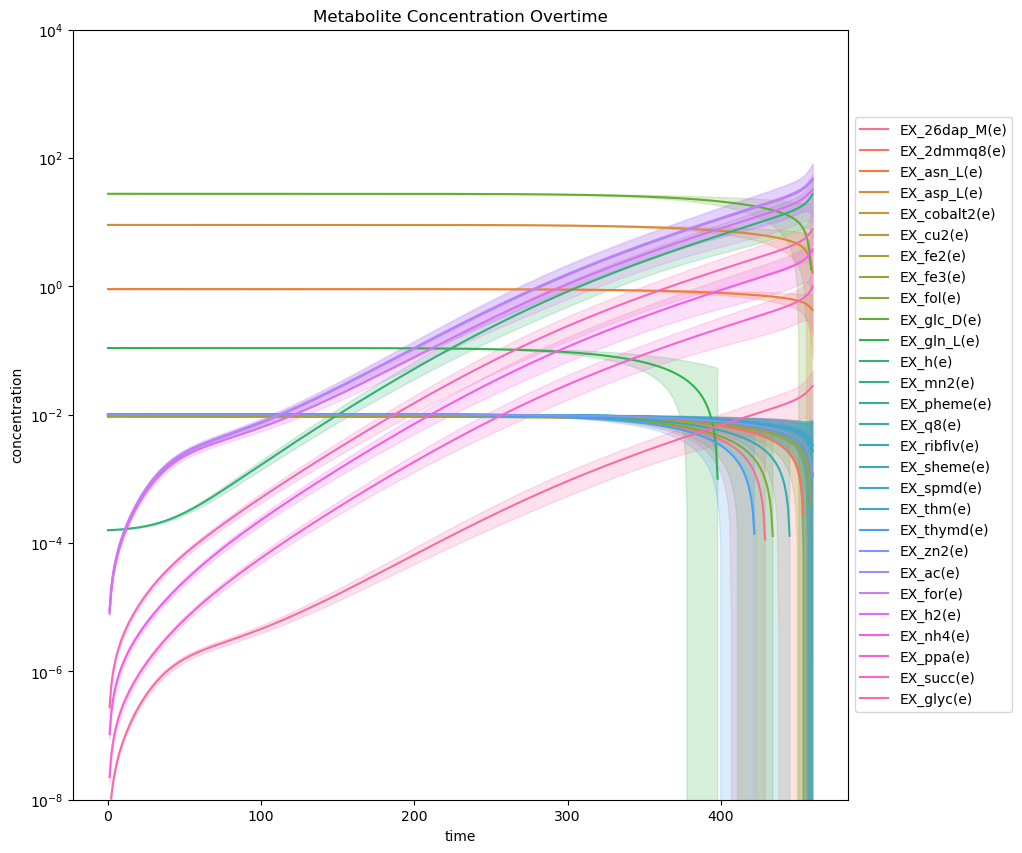

In [80]:

# Your existing lineplot
fig, axs = plt.subplots(figsize= (10,10))
sns.lineplot(data=df_means_unstack, x='time', y='fluxValue', hue='reaction')

# Loop over unique reactions and add CI
for i, reaction in enumerate(df_means_unstack['reaction'].unique()):
    # Filter the data for each reaction
    df_reaction = df_means_unstack[df_means_unstack['reaction'] == reaction]
    
    # Add fill for the confidence intervals
    color = axs.lines[i].get_color()
    plt.fill_between(df_reaction['time'], df_reaction['ci_lower'], df_reaction['ci_upper'], color =color, alpha=0.2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')
plt.ylim(10e-9,10000)
plt.title('Metabolite Concentration Overtime')
plt.xlabel('time')
plt.ylabel('concentration')
plt.show()


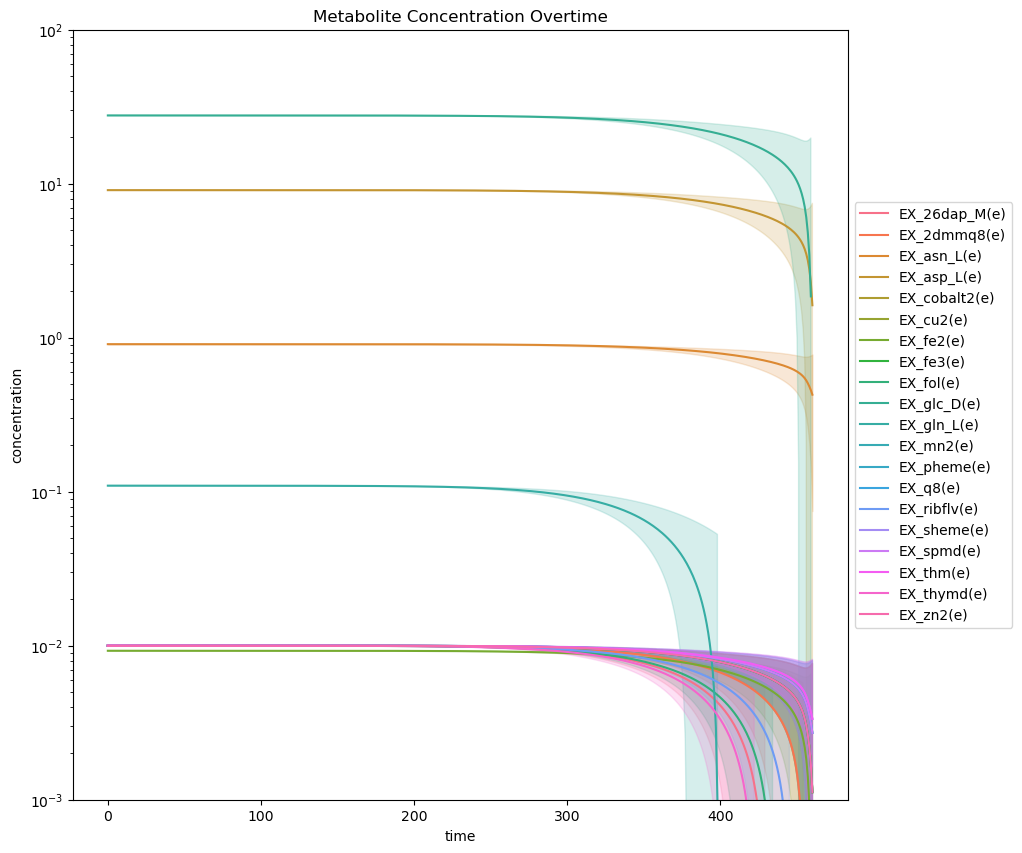

In [81]:

# Your existing lineplot
fig, axs = plt.subplots(figsize= (10,10))
sns.lineplot(data=df_means_unstack_pos, x='time', y='fluxValue', hue='reaction')

# Loop over unique reactions and add CI
for i, reaction in enumerate(df_means_unstack_pos['reaction'].unique()):
    # Filter the data for each reaction
    df_reaction = df_means_unstack_pos[df_means_unstack_pos['reaction'] == reaction]
    
    # Add fill for the confidence intervals
    color = axs.lines[i].get_color()
    plt.fill_between(df_reaction['time'], df_reaction['ci_lower'], df_reaction['ci_upper'], color =color, alpha=0.2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')
plt.ylim(10e-4,100)
plt.title('Metabolite Concentration Overtime')
plt.xlabel('time')
plt.ylabel('concentration')
plt.show()


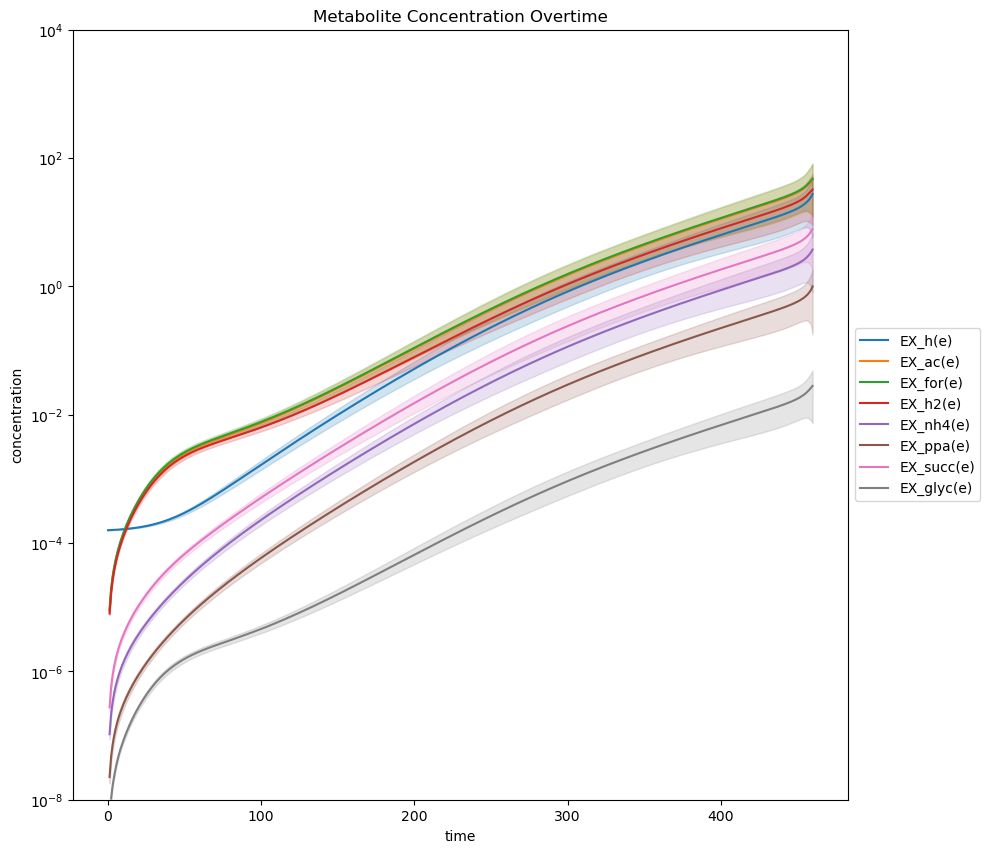

In [82]:

# Your existing lineplot
fig, axs = plt.subplots(figsize= (10,10))
sns.lineplot(data=df_means_unstack_neg, x='time', y='fluxValue', hue='reaction')

# Loop over unique reactions and add CI
for i, reaction in enumerate(df_means_unstack_neg['reaction'].unique()):
    # Filter the data for each reaction
    df_reaction = df_means_unstack_neg[df_means_unstack_neg['reaction'] == reaction]
    
    # Add fill for the confidence intervals
    color = axs.lines[i].get_color()
    plt.fill_between(df_reaction['time'], df_reaction['ci_lower'], df_reaction['ci_upper'], color =color, alpha=0.2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')
plt.ylim(10e-9,10000)
plt.title('Metabolite Concentration Overtime')
plt.xlabel('time')
plt.ylabel('concentration')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_4829/1132282710.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,100000)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_4829/1132282710.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,100000)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_4829/1132282710.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be i

IndexError: index 8 is out of bounds for axis 0 with size 8

/Users/haydengallo/anaconda3/envs/cobra_agorra/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/Users/haydengallo/anaconda3/envs/cobra_agorra/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


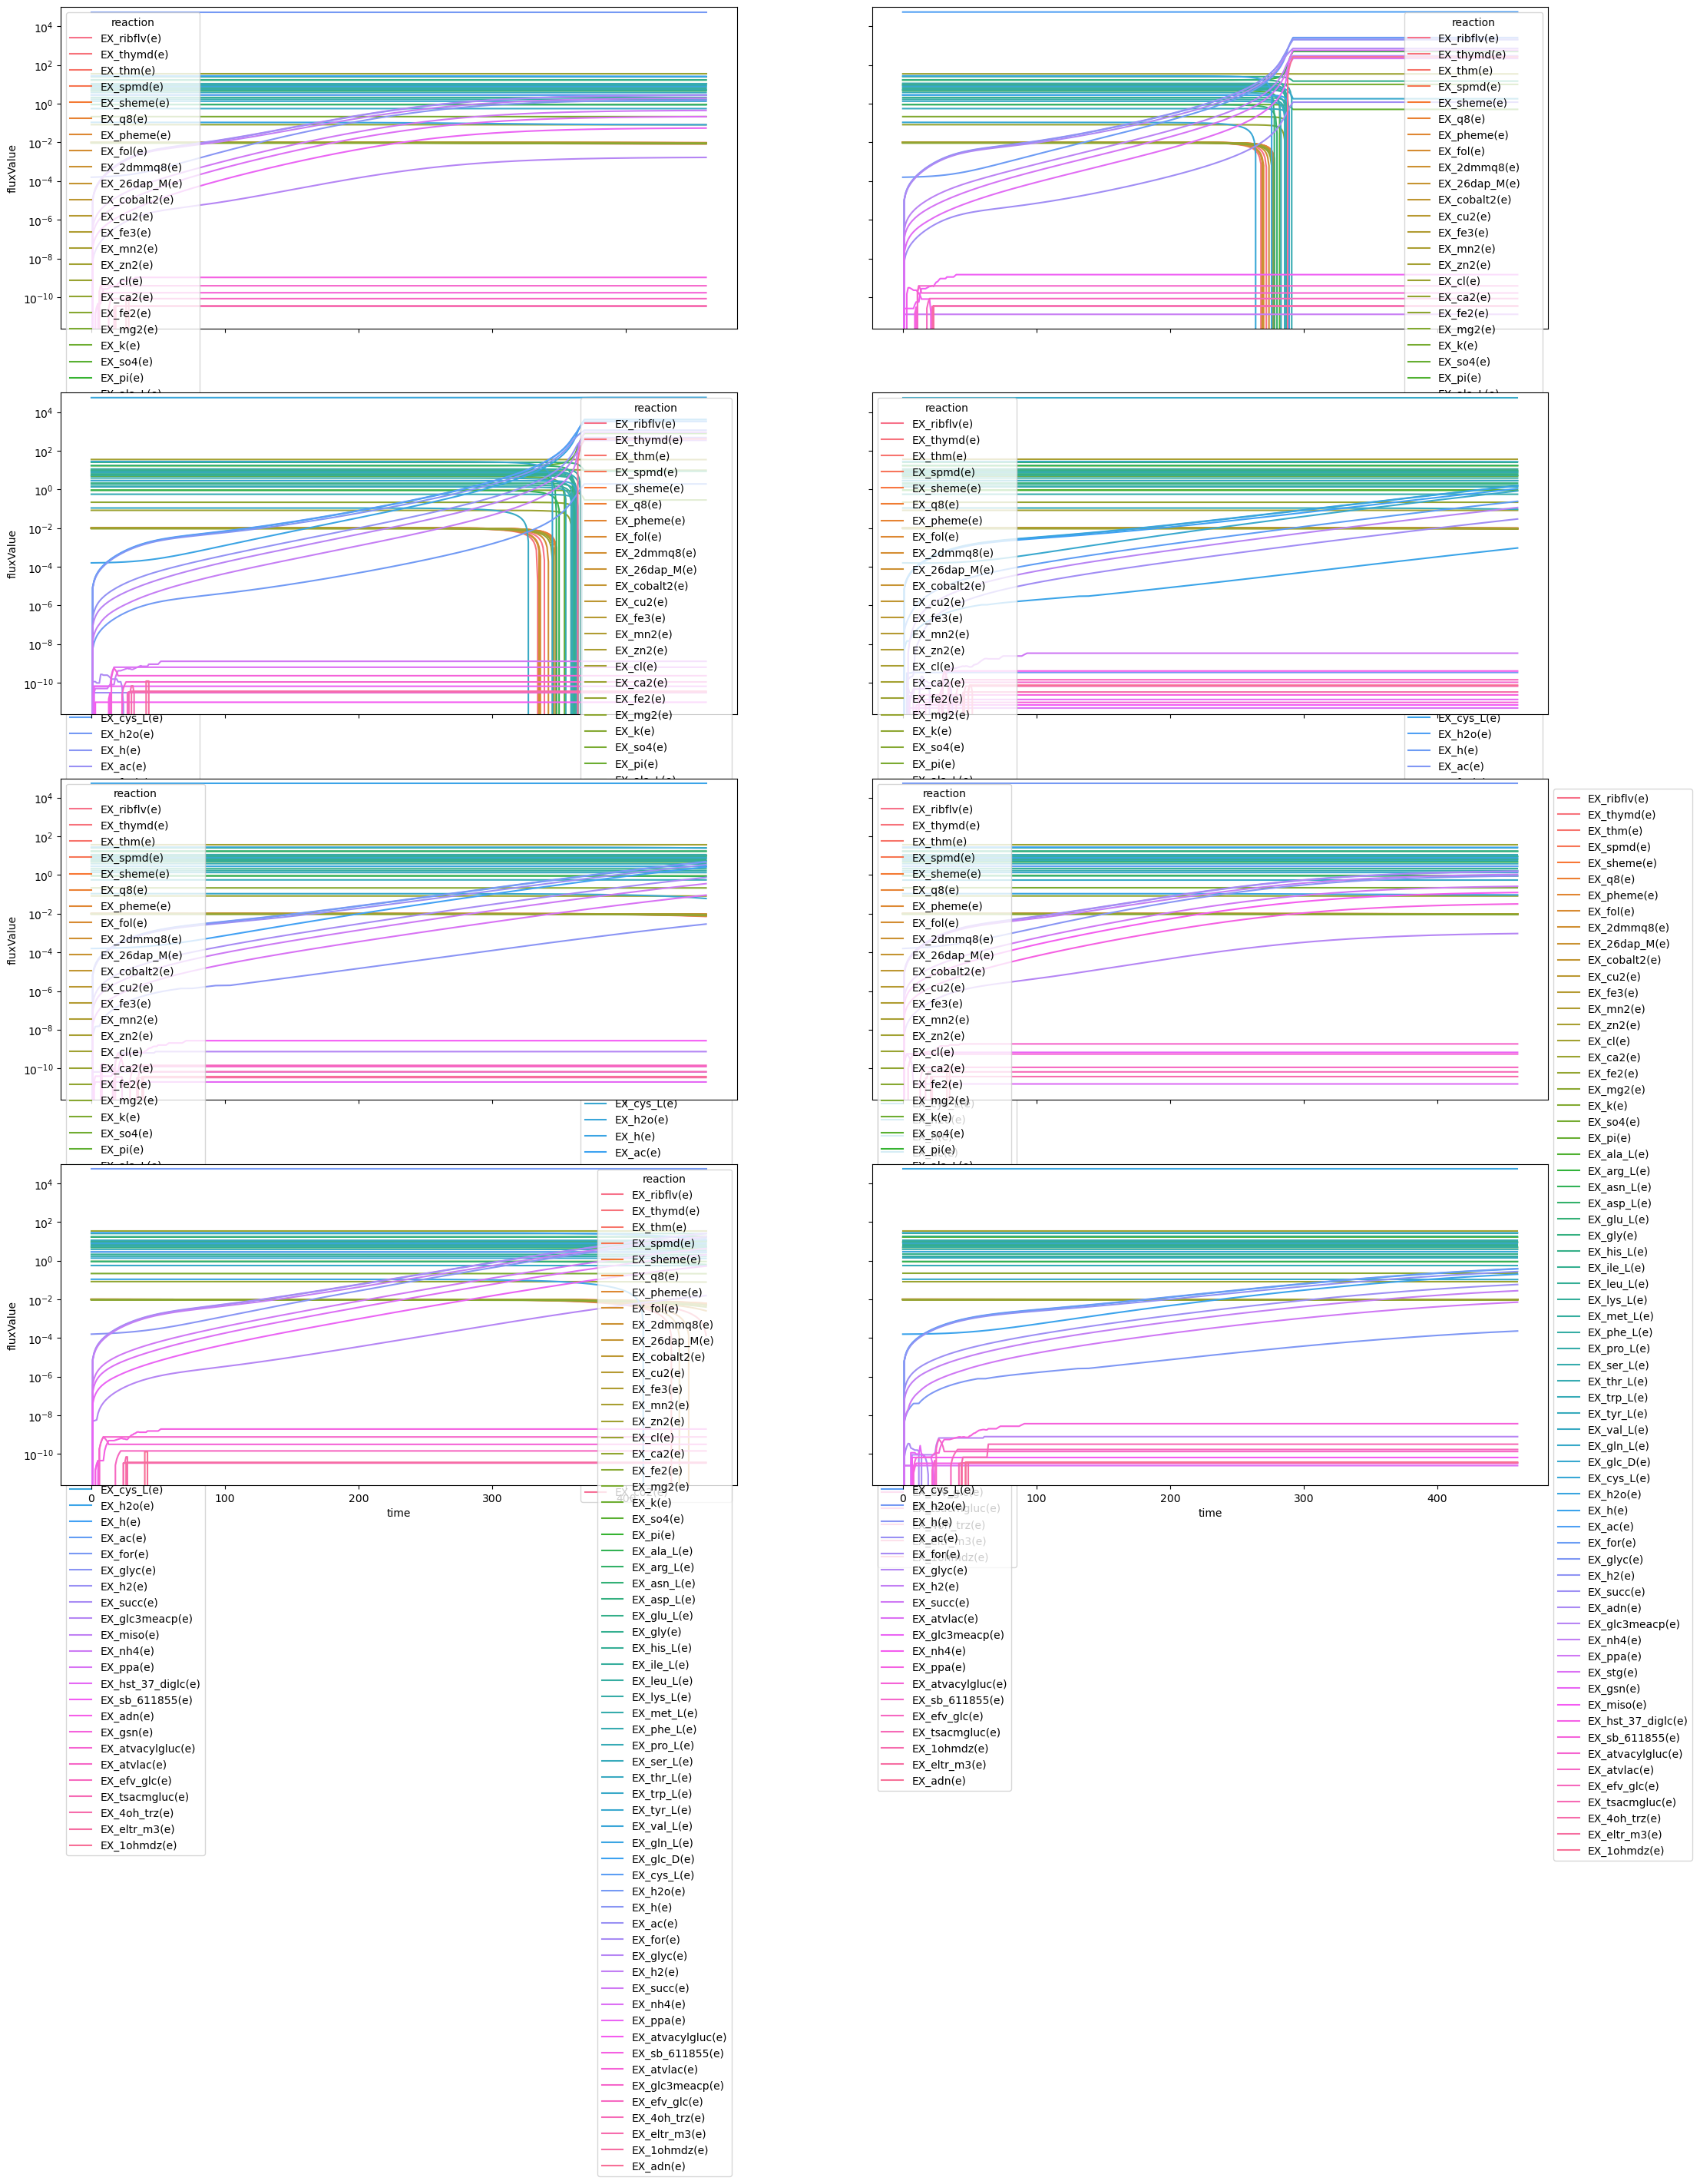

In [18]:
fig, axs = plt.subplots(figsize= (25,25),ncols = 2, nrows = 4, constrained_layout = True, sharex=True, sharey=True)
axs = axs.flatten()

for i in range(0, len(df_met_storage)):

    sns.lineplot(data = df_met_storage[i], x='time', y='fluxValue', hue = 'reaction', ax=axs[i])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.yscale('log')
    plt.ylim(0,100000)

/var/folders/5n/y6k0c8y951n38r8ccc6trh1m0000gn/T/ipykernel_16406/1150844251.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,100000)


(9.708055686716808e-14, 100000)

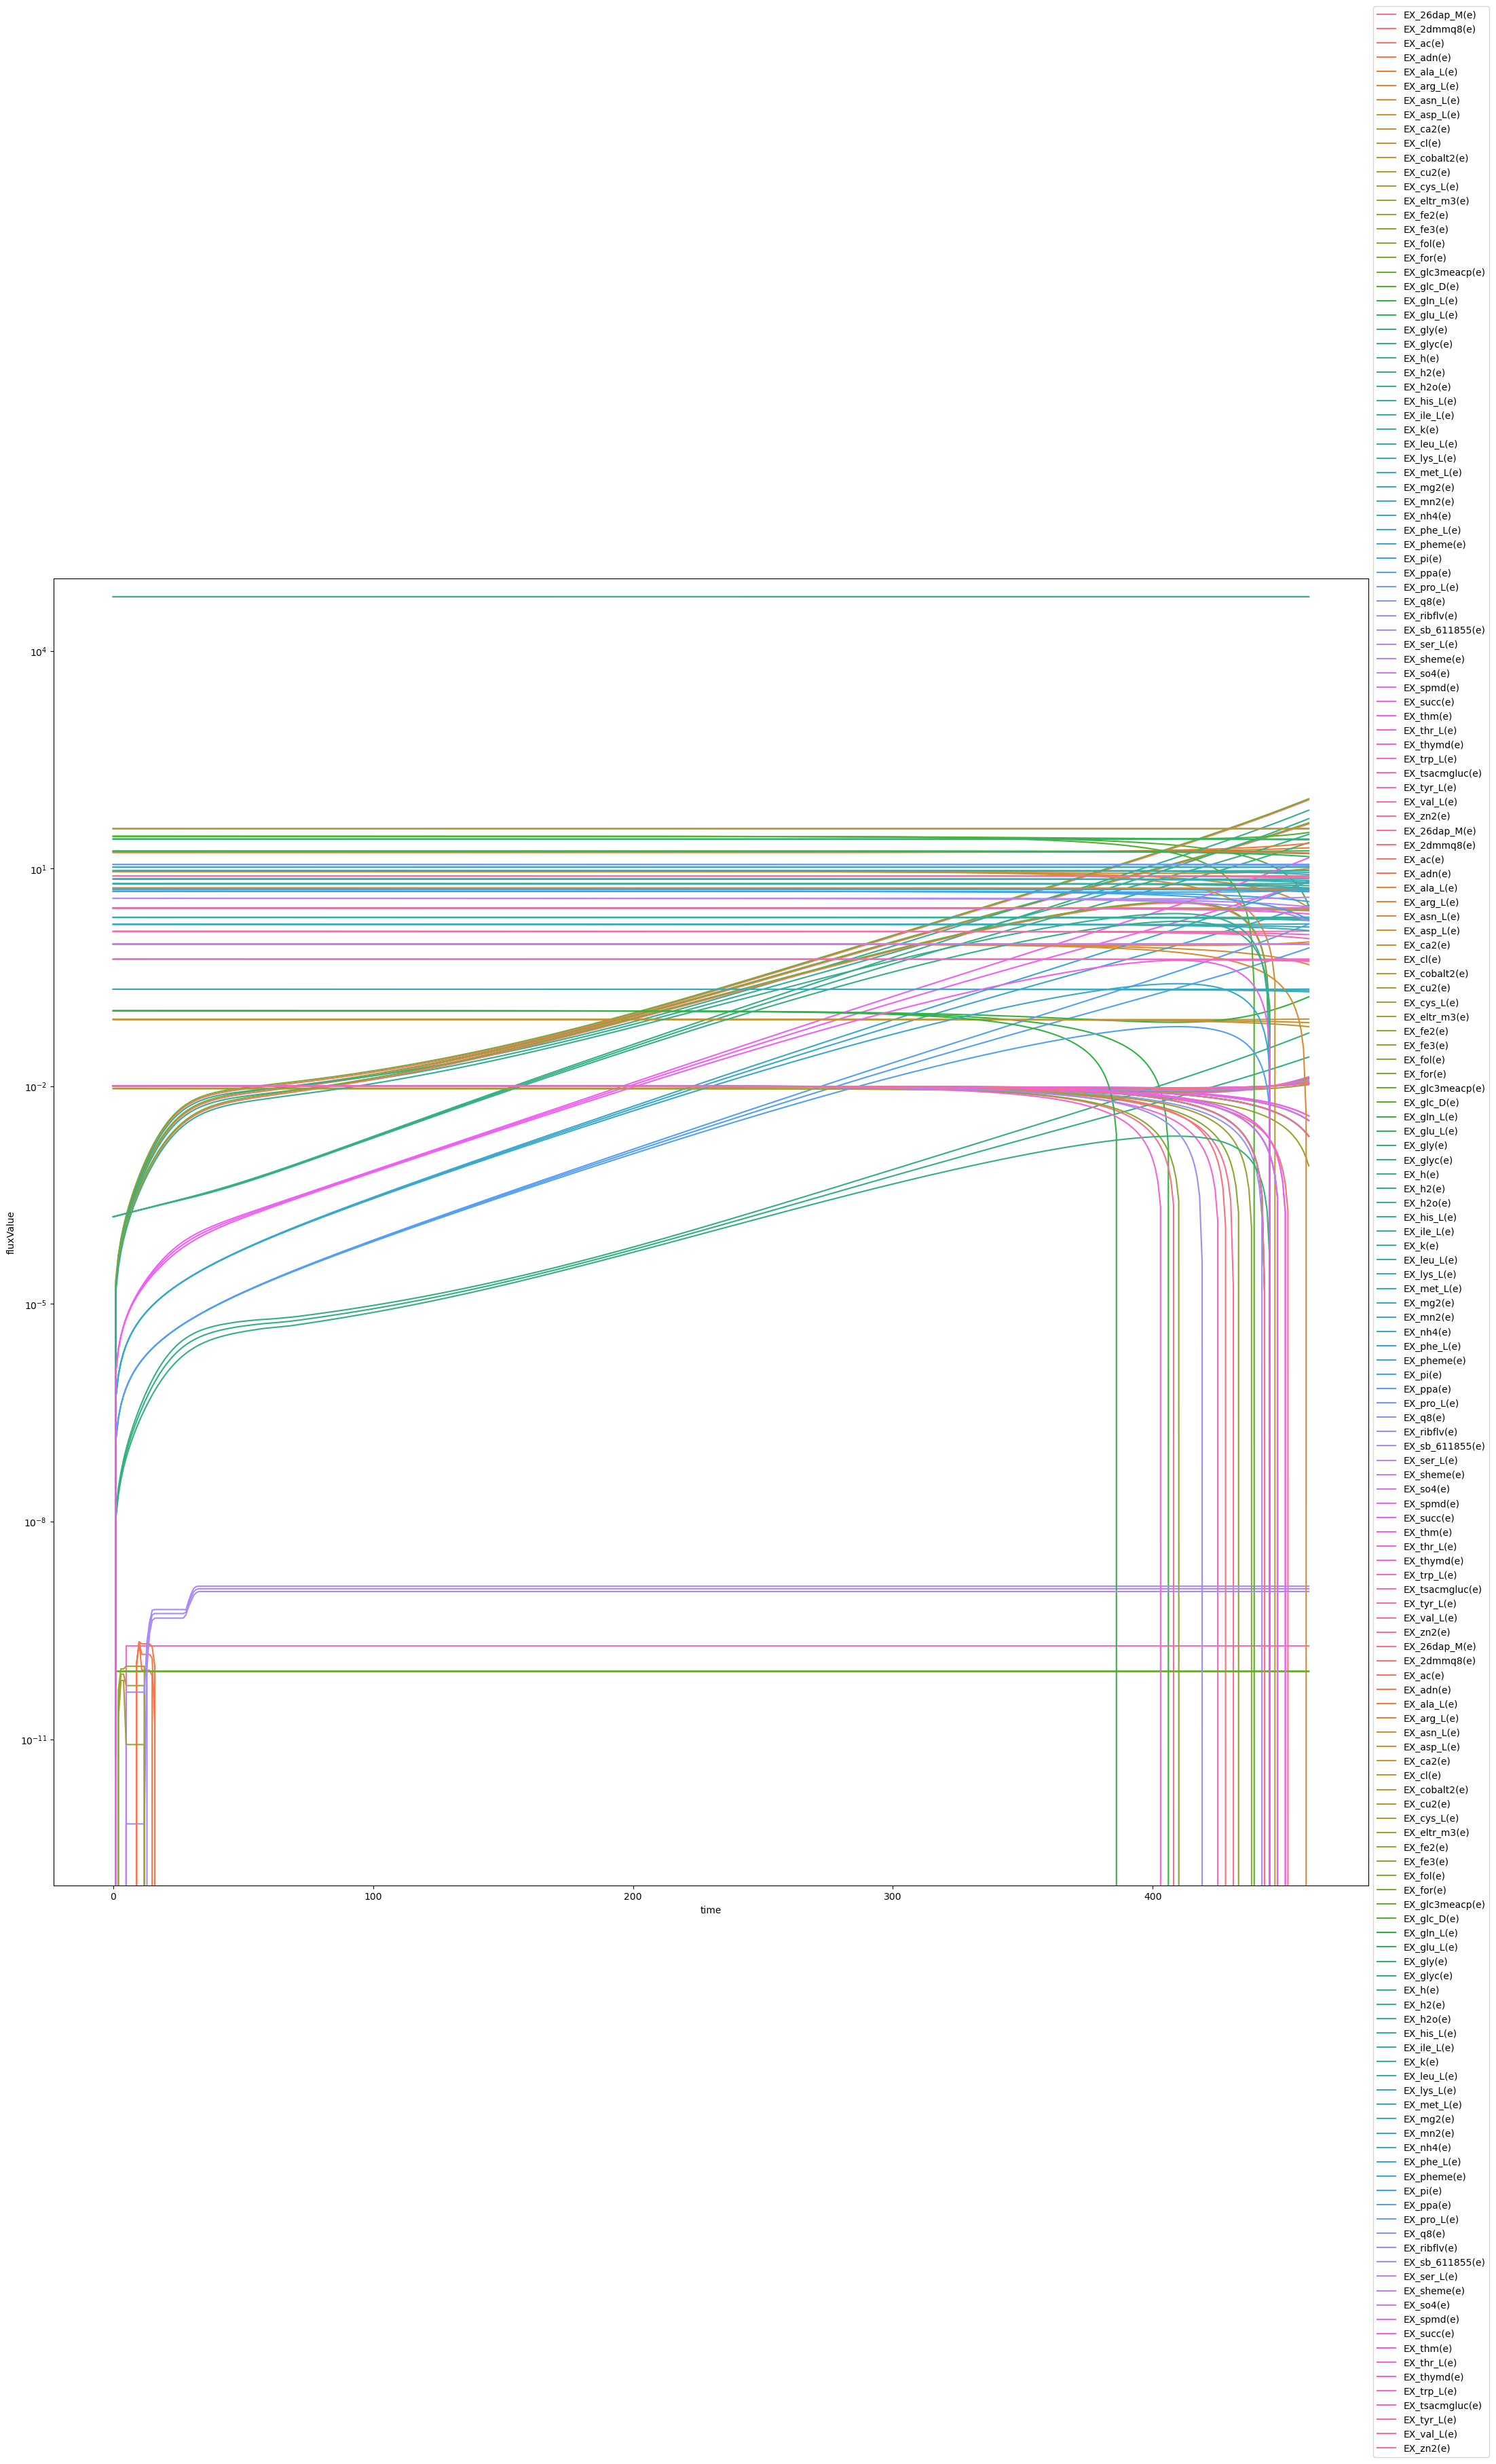

In [ ]:
fig, axs = plt.subplots(figsize= (25,25))


sns.lineplot(data = df_means_unstack, x='time', y='fluxValue', hue = 'reaction')
sns.lineplot(data = upper_ci_unstack, x='time', y='fluxValue', hue = 'reaction')
sns.lineplot(data = lower_ci_unstack, x='time', y='fluxValue', hue = 'reaction')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')
plt.ylim(0,100000)

In [19]:
len(abun_to_store[0].keys())

eb_array = np.zeros([len(abun_to_store[0]['eb']['glv_out']), len(abun_to_store)])
pc_array = np.zeros([len(abun_to_store[0]['eb']['glv_out']), len(abun_to_store)])

#for i in range(abun_to_store[0].keys())
eb_array.shape

(461, 99)

In [20]:
for i in range(0, len(abun_to_store)):
    eb_array[:,i] = abun_to_store[i]['eb']['glv_out']
    pc_array[:,i] = abun_to_store[i]['p_copri']['glv_out']

In [21]:
eb_std = np.std(eb_array, axis=1)
eb_mean = np.mean(eb_array, axis=1)

pc_std = np.std(pc_array, axis=1)
pc_mean = np.mean(pc_array, axis=1)

/Users/haydengallo/anaconda3/envs/cobra_agorra/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [22]:
eb_df = pd.DataFrame(eb_array)
pc_df = pd.DataFrame(pc_array)

In [23]:
eb_df_long = eb_df.unstack().reset_index()
pc_df_long = pc_df.unstack().reset_index()

In [24]:
eb_df_long.columns = ['extra','time','abun']
pc_df_long.columns = ['extra','time','abun']

In [25]:
cerillo_test_data = pd.read_csv('/Users/haydengallo/Documents/Bucci_Lab/cerillo_data/averaged_cerillo.csv', index_col=0)
test_df = cerillo_test_data[(cerillo_test_data['Group_together'] == 'PCwEB') | (cerillo_test_data['Group_together'] == 'EBwPC')]
microbe_data = test_df.pivot(index='Time', columns= 'Group_together', values = 'OD').reset_index()

microbe_data.head()


Group_together,Time,EBwPC,PCwEB
0,0,0.002300,0.002633
1,5,0.001933,0.002033
2,10,0.003533,0.004433
3,15,0.005367,0.007000
4,20,0.007333,0.009333


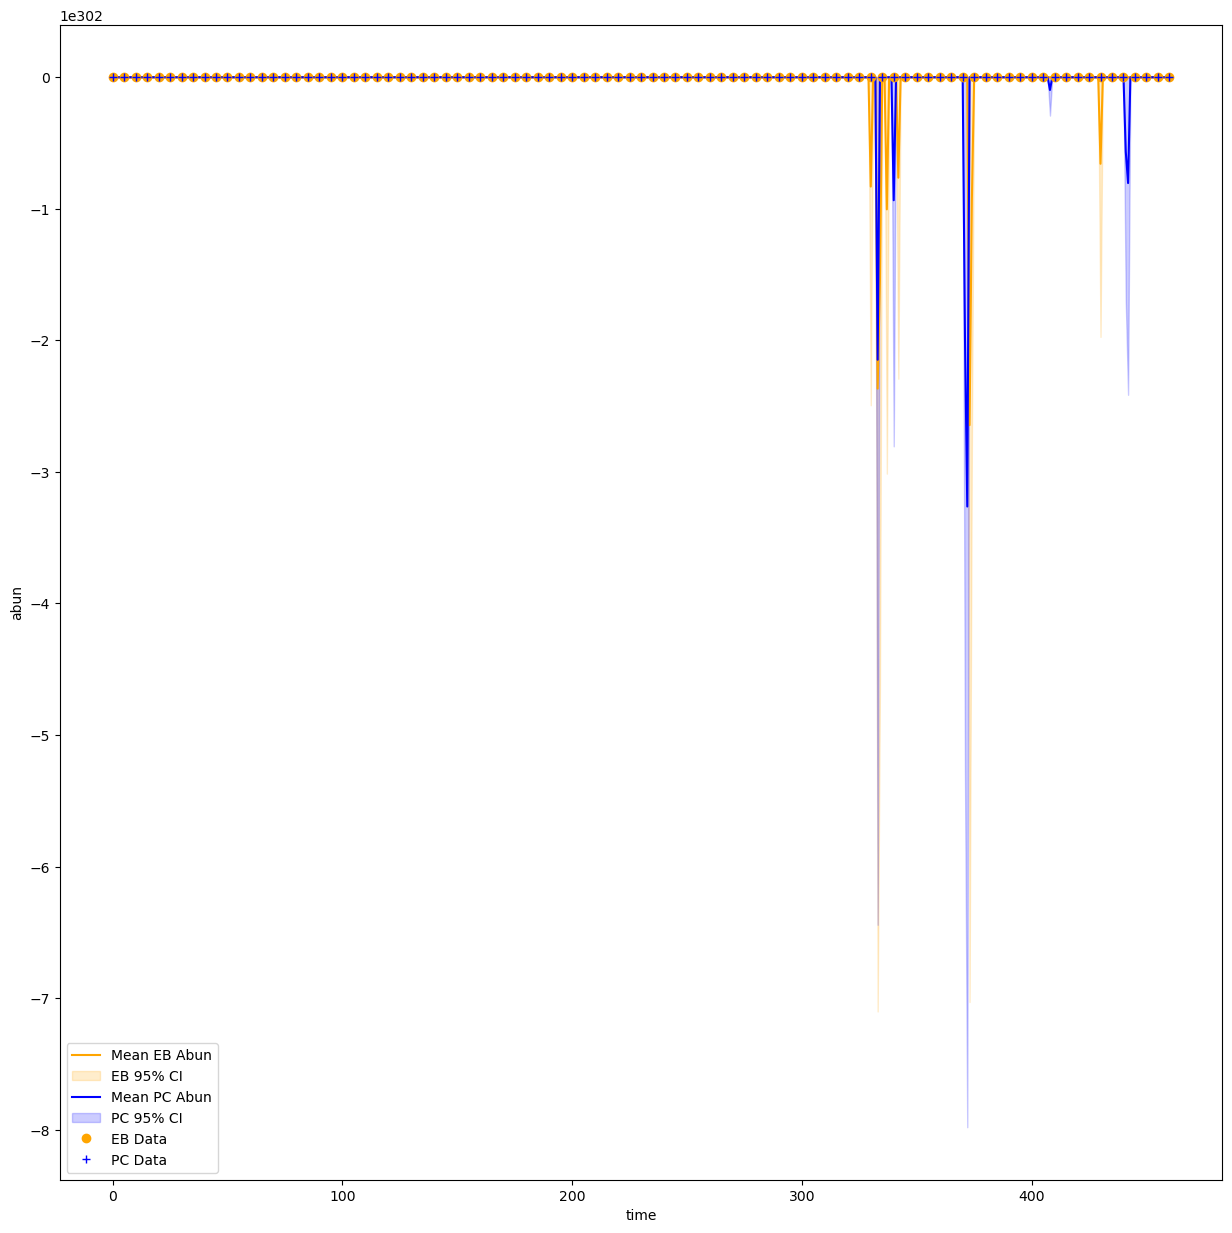

In [26]:
fig, axs = plt.subplots(figsize= (15,15))
sns.lineplot(data=eb_df_long, x='time', y='abun', color = 'orange')
sns.lineplot(data=pc_df_long, x='time', y='abun', color = 'blue')
axs.plot(microbe_data['Time'], microbe_data['EBwPC'], marker = 'o', lw =0, label = 'EB (data)', color = 'orange')
axs.plot(microbe_data['Time'], microbe_data['PCwEB'], marker = '+', lw =0, label = 'PC (data)', color = 'blue')
axs.legend(['Mean EB Abun', 'EB 95% CI', 'Mean PC Abun', 'PC 95% CI', 'EB Data', 'PC Data'])

In [27]:
to_keep = []
for i in range(0, 99):
    if abun_to_store[i]['p_copri']['glv_out'][-1] < 1e-5:
        continue
    if abun_to_store[i]['p_copri']['glv_out'][-1] > 10:
        continue
    else:
        to_keep.append(i)

In [28]:
to_keep


[0,
 3,
 4,
 5,
 6,
 7,
 8,
 10,
 11,
 13,
 15,
 16,
 18,
 20,
 21,
 24,
 26,
 28,
 29,
 32,
 34,
 35,
 38,
 39,
 40,
 41,
 44,
 46,
 48,
 52,
 53,
 58,
 59,
 62,
 63,
 64,
 65,
 66,
 68,
 69,
 71,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 86,
 87,
 89,
 90,
 91,
 92,
 93,
 95,
 97,
 98]

In [29]:
eb_array_filt = np.zeros([len(abun_to_store[0]['eb']['glv_out']), len(abun_to_store)])
pc_array_filt = np.zeros([len(abun_to_store[0]['eb']['glv_out']), len(abun_to_store)])

for i in range(0, len(abun_to_store)):
    eb_array_filt[:,i] = abun_to_store[i]['eb']['glv_out']
    pc_array_filt[:,i] = abun_to_store[i]['p_copri']['glv_out']




In [30]:
eb_array_filt = eb_array_filt[:,to_keep]
pc_array_filt = pc_array_filt[:,to_keep]

In [31]:

eb_std_filt = np.std(eb_array_filt, axis=1)
eb_mean_filt = np.mean(eb_array_filt, axis=1)

pc_std_filt = np.std(pc_array, axis=1)
pc_mean_filt = np.mean(pc_array, axis=1)

eb_df_filt = pd.DataFrame(eb_array_filt)
pc_df_filt = pd.DataFrame(pc_array_filt)

eb_df_long_filt = eb_df_filt.unstack().reset_index()
pc_df_long_filt = pc_df_filt.unstack().reset_index()

eb_df_long_filt.columns = ['extra','time','abun']
pc_df_long_filt.columns = ['extra','time','abun']

/Users/haydengallo/anaconda3/envs/cobra_agorra/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Text(0.5, 1.0, 'Mean Trace from Posterior vs. PC and EB Abundance Data')

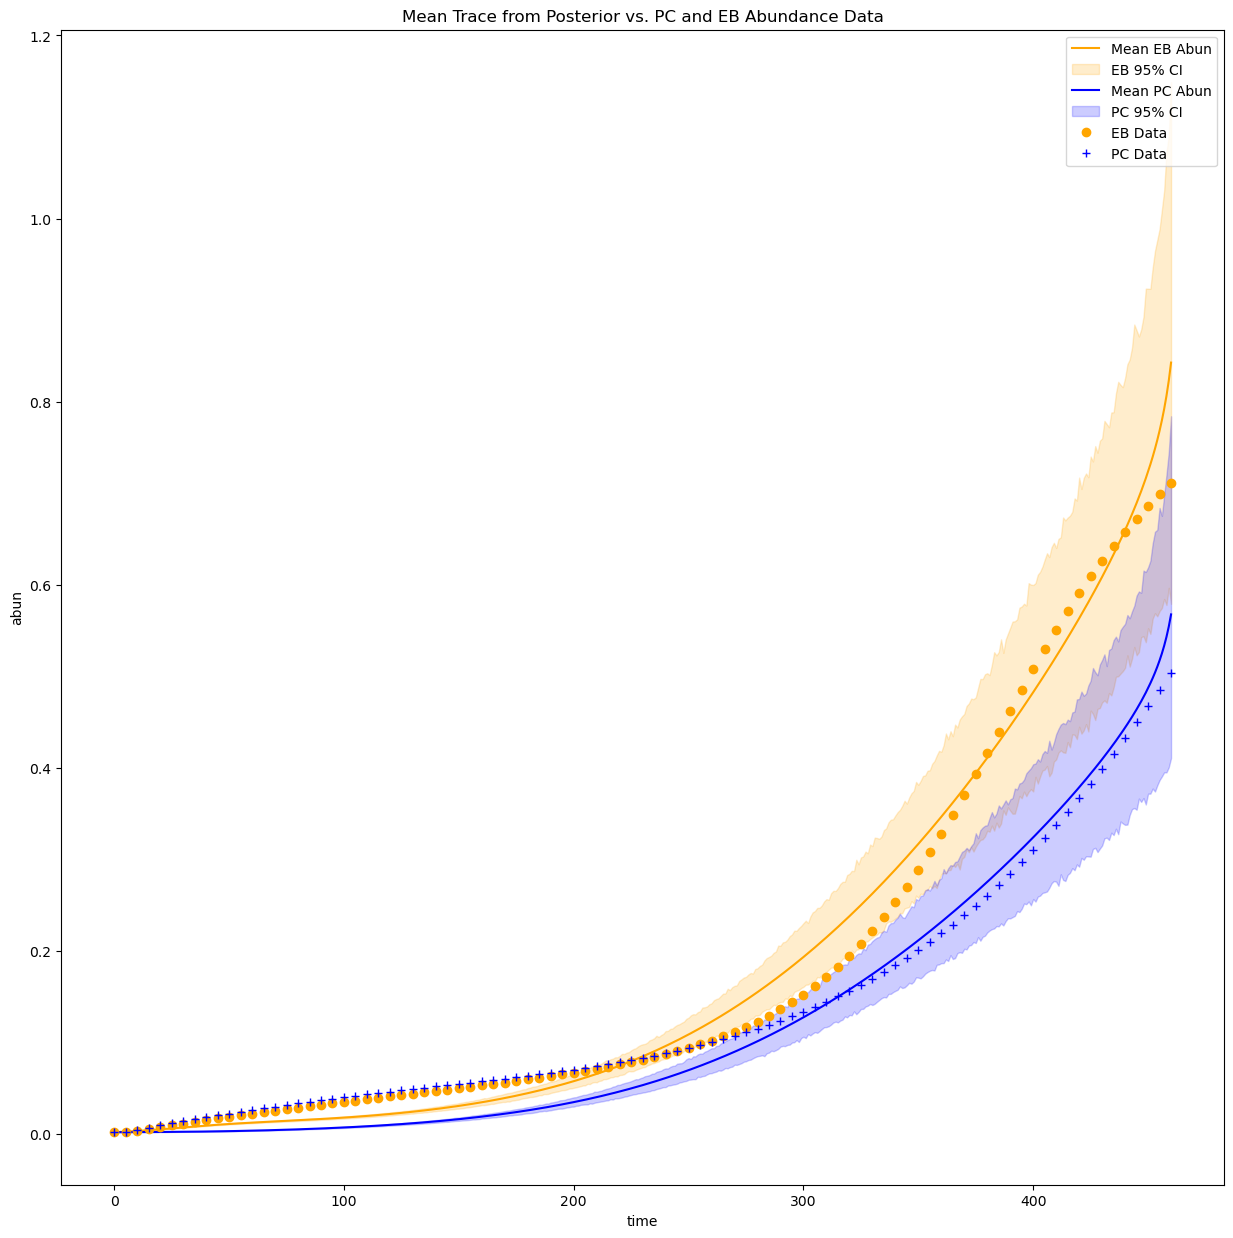

In [64]:
fig, axs = plt.subplots(figsize= (15,15))
sns.lineplot(data=eb_df_long_filt, x='time', y='abun', color = 'orange')
sns.lineplot(data=pc_df_long_filt, x='time', y='abun', color = 'blue')
axs.plot(microbe_data['Time'], microbe_data['EBwPC'], marker = 'o', lw =0, label = 'EB (data)', color = 'orange')
axs.plot(microbe_data['Time'], microbe_data['PCwEB'], marker = '+', lw =0, label = 'PC (data)', color = 'blue')
axs.legend(['Mean EB Abun', 'EB 95% CI', 'Mean PC Abun', 'PC 95% CI', 'EB Data', 'PC Data'])
axs.set_title('Mean Trace from Posterior vs. PC and EB Abundance Data')